<a href="https://colab.research.google.com/github/michael-a7/Telework-Eligibility-Classification/blob/main/Machine_Learning_on_Telework_Eligibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Extraction

Import Necessary Packages (Uncomment and run following cell if missing packages)

In [47]:
!pip install requests pandas numpy scipy category_encoders

In [48]:
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
import json
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

**First Time: Retrieve data from API and save JSON file for reproducibility.**

In [49]:
# url = "https://data.usajobs.gov/api/search?Keyword=Information%20Technology&ResultsPerPage=500"

# headers = {
#     "Host": "data.usajobs.gov",
#     "User-Agent": "YOUR_EMAIL_HERE",
#     "Authorization-Key": "YOUR_KEY_HERE"}

# response = requests.get(url,headers=headers)
# data = response.json()
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# filename = f'usa_jobs_{timestamp}.json'
# with open(filename, 'w') as f:
#     json.dump(data, f)

**Subsequent Times: retrieve data from saved JSON file.**

For reproducibility, use the saved file, `usa_jobs_2025-05-05_22-00-27.json`.

In [50]:
with open('/content/usa_jobs_2025-05-05_22-00-27.json','r') as f:
  data = json.load(f)

Create and view Pandas dataframe

In [51]:
job_items = data['SearchResult']['SearchResultItems']
descriptor = [job['MatchedObjectDescriptor'] for job in job_items]
df = pd.json_normalize(descriptor)
df
#Feel free to comment or uncomment lines that only view the changes to data tables

,PositionID,PositionTitle,PositionURI,ApplyURI,PositionLocationDisplay,PositionLocation,OrganizationName,DepartmentName,SubAgency,JobCategory,...,UserArea.Details.BargainingUnitStatus,UserArea.IsRadialSearch,UserArea.Details.SecondAnnouncementUrl,UserArea.Details.AnnouncementClosingTypeOption,UserArea.Details.PositionSensitivitiy,UserArea.Details.PromotionPotentialAdditionalText,UserArea.Details.FinancialDisclosureAdditionalText,UserArea.Details.BargainingUnitStatusAdditionalText,UserArea.Details.AgencyContactWebsite,UserArea.Details.PreviewQuestionnaireurl
0,OIT-SMP-12730966-ART,Information Technology Specialist,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,Multiple Locations,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",Customs and Border Protection,Department of Homeland Security,Office of Information and Technology,"[{'Name': 'Information Technology Management',...",...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IHS-25-HQ-12730805-ESEP/MP,Supervisory Information Technology Specialist ...,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,"Rockville, Maryland","[{'LocationName': 'Rockville, Maryland', 'Coun...",Indian Health Service,Department of Health and Human Services,Headquarters | Office of Information Technolog...,"[{'Name': 'Information Technology Management',...",...,False,False,836099800,50,High Risk (HR),NaN,NaN,NaN,NaN,NaN
2,CMS-OIT-25-12730619-IMP,IT Specialist (Policy & Planning),https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,"Woodlawn, Maryland","[{'LocationName': 'Woodlawn, Maryland', 'Count...",Centers for Medicare & Medicaid Services,Department of Health and Human Services,Office of Information Technology (OIT),"[{'Name': 'Information Technology Management',...",...,True,False,NaN,NaN,Moderate Risk (MR),NaN,NaN,NaN,NaN,NaN
3,IHS-25-HQ-12730806-DE,Supervisory Information Technology Specialist ...,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,"Rockville, Maryland","[{'LocationName': 'Rockville, Maryland', 'Coun...",Indian Health Service,Department of Health and Human Services,Headquarters | Office of Information Technolog...,"[{'Name': 'Information Technology Management',...",...,False,False,836099000,50,High Risk (HR),NaN,NaN,NaN,NaN,NaN
4,IHS-25-HQ-12731977-ESEP/MP,Information Technology Specialist (Network Ser...,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,Location Negotiable After Selection,"[{'LocationName': 'Salt Lake City, Utah', 'Cou...",Indian Health Service,Department of Health and Human Services,Headquarters | Office of Information Technolog...,"[{'Name': 'Information Technology Management',...",...,True,False,836294700,50,High Risk (HR),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CBTG-12732456-25-TMB,Surgical Technician,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,"Lexington, Kentucky","[{'LocationName': 'Lexington, Kentucky', 'Coun...",Veterans Health Administration,Department of Veterans Affairs,Veterans Health Administration,"[{'Name': 'Health Aid And Technician', 'Code':...",...,True,False,NaN,NaN,Non-sensitive (NS)/Low Risk,NaN,NaN,NaN,NaN,NaN
496,12691569 BGM-PT,Transportation Security Officer,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov:443/GetJob/ViewDetail...,"Binghamton, New York","[{'LocationName': 'Binghamton, New York', 'Cou...",Transportation Security Administration,Department of Homeland Security,NaN,"[{'Name': 'Compliance Inspection And Support',...",...,False,False,NaN,NaN,Noncritical-Sensitive (NCS)/Moderate Risk,NaN,NaN,NaN,NaN,NaN
497,12691661-FAI-FT-PT,Transportation Security Officer,https://www.usajobs.gov:443/GetJob/ViewDetails...,[https://www.usajobs.gov

# Dataset Cleaning

Rename column for easier use

In [52]:
df.rename(columns={
    "UserArea.Details.TeleworkEligible": "TeleworkEligible",
    }, inplace=True)

Create `Working_Table` with necessary columns.

`PositionRenumeration` values are JSON/dictionary items nested in an array, so I'll flatten them from the array.

In [53]:
Working_Table = df[['PositionID', 'PositionLocation','PositionRemuneration','TeleworkEligible']]
Working_Table['PositionRemuneration'] =  Working_Table['PositionRemuneration'].str[0]
Working_Table #(Verify changes)

<ipython-input-53-f318a65808be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Working_Table['PositionRemuneration'] =  Working_Table['PositionRemuneration'].str[0]


,PositionID,PositionLocation,PositionRemuneration,TeleworkEligible
0,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...","{'MinimumRange': '73939', 'MaximumRange': '115...",False
1,IHS-25-HQ-12730805-ESEP/MP,"[{'LocationName': 'Rockville, Maryland', 'Coun...","{'MinimumRange': '167603', 'MaximumRange': '19...",False
2,CMS-OIT-25-12730619-IMP,"[{'LocationName': 'Woodlawn, Maryland', 'Count...","{'MinimumRange': '142488', 'MaximumRange': '18...",True
3,IHS-25-HQ-12730806-DE,"[{'LocationName': 'Rockville, Maryland', 'Coun...","{'MinimumRange': '167603', 'MaximumRange': '19...",False
4,IHS-25-HQ-12731977-ESEP/MP,"[{'LocationName': 'Salt Lake City, Utah', 'Cou...","{'MinimumRange': '120579', 'MaximumRange': '15...",False
...,...,...,...,...
495,CBTG-12732456-25-TMB,"[{'LocationName': 'Lexington, Kentucky', 'Coun...","{'MinimumRange': '54365', 'MaximumRange': '706...",False
496,12691569 BGM-PT,"[{'LocationName': 'Binghamton, New York', 'Cou...","{'MinimumRange': '40332', 'MaximumRange': '562...",False
497,12691661-FAI-FT-PT,"[{'LocationName': 'Fairbanks, Alaska', 'Countr...","{'MinimumRange': '54965', 'MaximumRange': '678...",False
498,12701190-MTJ-FT-PT,"[{'LocationName': 'Montrose, Colorado', 'Count...","{'MinimumRange': '40332', 'MaximumRange': '562...",False


`PoistionRemuneration` has several values in a dictionary/JSON object: `MinimumRange`, `MaximumRange`, `RateIntervalCode`, and `Description`.

Therefore, we will expand each of these values as their own columns in the dataframe. We will also drop the original `PoistionRemuneration` dimension, as well as `RateIntervalCode` and `MaximumRange`.

In [54]:
Working_Table = pd.concat([
Working_Table.drop(columns=['PositionRemuneration']),
pd.json_normalize(Working_Table['PositionRemuneration'])
 ],axis = 1) #Gets values from JSON as their own dataframe columns
Working_Table #(Verify changes)

,PositionID,PositionLocation,TeleworkEligible,MinimumRange,MaximumRange,RateIntervalCode,Description
0,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,115213,PA,Per Year
1,IHS-25-HQ-12730805-ESEP/MP,"[{'LocationName': 'Rockville, Maryland', 'Coun...",False,167603,195200,PA,Per Year
2,CMS-OIT-25-12730619-IMP,"[{'LocationName': 'Woodlawn, Maryland', 'Count...",True,142488,185234,PA,Per Year
3,IHS-25-HQ-12730806-DE,"[{'LocationName': 'Rockville, Maryland', 'Coun...",False,167603,195200,PA,Per Year
4,IHS-25-HQ-12731977-ESEP/MP,"[{'LocationName': 'Salt Lake City, Utah', 'Cou...",False,120579,156755,PA,Per Year
...,...,...,...,...,...,...,...
495,CBTG-12732456-25-TMB,"[{'LocationName': 'Lexington, Kentucky', 'Coun...",False,54365,70678,PA,Per Year
496,12691569 BGM-PT,"[{'LocationName': 'Binghamton, New York', 'Cou...",False,40332,56282,PA,Per Year
497,12691661-FAI-FT-PT,"[{'LocationName': 'Fairbanks, Alaska', 'Countr...",False,54965,67816,PA,Per Year
498,12701190-MTJ-FT-PT,"[{'LocationName': 'Montrose, Colorado', 'Count...",False,40332,56282,PA,Per Year


Drop unnecessary columns.

In [55]:
Working_Table.drop(columns=['RateIntervalCode', 'MaximumRange'], inplace=True)
Working_Table #(Verify changes)

,PositionID,PositionLocation,TeleworkEligible,MinimumRange,Description
0,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,Per Year
1,IHS-25-HQ-12730805-ESEP/MP,"[{'LocationName': 'Rockville, Maryland', 'Coun...",False,167603,Per Year
2,CMS-OIT-25-12730619-IMP,"[{'LocationName': 'Woodlawn, Maryland', 'Count...",True,142488,Per Year
3,IHS-25-HQ-12730806-DE,"[{'LocationName': 'Rockville, Maryland', 'Coun...",False,167603,Per Year
4,IHS-25-HQ-12731977-ESEP/MP,"[{'LocationName': 'Salt Lake City, Utah', 'Cou...",False,120579,Per Year
...,...,...,...,...,...
495,CBTG-12732456-25-TMB,"[{'LocationName': 'Lexington, Kentucky', 'Coun...",False,54365,Per Year
496,12691569 BGM-PT,"[{'LocationName': 'Binghamton, New York', 'Cou...",False,40332,Per Year
497,12691661-FAI-FT-PT,"[{'LocationName': 'Fairbanks, Alaska', 'Countr...",False,54965,Per Year
498,12701190-MTJ-FT-PT,"[{'LocationName': 'Montrose, Colorado', 'Count...",False,40332,Per Year


Similar to `PoistionRemuneration`, the dimension `PositionLocation` has several nested values, which we will expand in the same way.

In [56]:
location_table = df[['PositionID','PositionLocation']]
location_table #(Verify changes)

,PositionID,PositionLocation
0,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr..."
1,IHS-25-HQ-12730805-ESEP/MP,"[{'LocationName': 'Rockville, Maryland', 'Coun..."
2,CMS-OIT-25-12730619-IMP,"[{'LocationName': 'Woodlawn, Maryland', 'Count..."
3,IHS-25-HQ-12730806-DE,"[{'LocationName': 'Rockville, Maryland', 'Coun..."
4,IHS-25-HQ-12731977-ESEP/MP,"[{'LocationName': 'Salt Lake City, Utah', 'Cou..."
...,...,...
495,CBTG-12732456-25-TMB,"[{'LocationName': 'Lexington, Kentucky', 'Coun..."
496,12691569 BGM-PT,"[{'LocationName': 'Binghamton, New York', 'Cou..."
497,12691661-FAI-FT-PT,"[{'LocationName': 'Fairbanks, Alaska', 'Countr..."
498,12701190-MTJ-FT-PT,"[{'LocationName': 'Montrose, Colorado', 'Count..."


Before expanding, we will use the `.explode` method to account for each location in the case of jobs with multiple listed locations. This way, some PositionIDs will be listed multiple times, but each row will have 1 location.

In [57]:
location_explode = location_table.explode('PositionLocation',ignore_index=True)
location_explode #(Verify changes)

,PositionID,PositionLocation
0,OIT-SMP-12730966-ART,"{'LocationName': 'Anchorage, Alaska', 'Country..."
1,OIT-SMP-12730966-ART,"{'LocationName': 'Juneau, Alaska', 'CountryCod..."
2,OIT-SMP-12730966-ART,"{'LocationName': 'Tampa, Florida', 'CountryCod..."
3,OIT-SMP-12730966-ART,"{'LocationName': 'Fairfax, Vermont', 'CountryC..."
4,IHS-25-HQ-12730805-ESEP/MP,"{'LocationName': 'Rockville, Maryland', 'Count..."
...,...,...
2435,CBTG-12732456-25-TMB,"{'LocationName': 'Lexington, Kentucky', 'Count..."
2436,12691569 BGM-PT,"{'LocationName': 'Binghamton, New York', 'Coun..."
2437,12691661-FAI-FT-PT,"{'LocationName': 'Fairbanks, Alaska', 'Country..."
2438,12701190-MTJ-FT-PT,"{'LocationName': 'Montrose, Colorado', 'Countr..."


In [58]:
location_normalize = pd.concat([
location_explode.drop(columns=['PositionLocation']),
pd.json_normalize(location_explode['PositionLocation'])
],axis = 1)
location_normalize.drop_duplicates(inplace=True)
location_normalize #(Verify changes)

,PositionID,LocationName,CountryCode,CountrySubDivisionCode,CityName,Longitude,Latitude,AddressLine
0,OIT-SMP-12730966-ART,"Anchorage, Alaska",United States,Alaska,"Anchorage, Alaska",-149.85774,61.217560,NaN
1,OIT-SMP-12730966-ART,"Juneau, Alaska",United States,Alaska,"Juneau, Alaska",-134.40680,58.299700,NaN
2,OIT-SMP-12730966-ART,"Tampa, Florida",United States,Florida,"Tampa, Florida",-82.45927,27.946530,NaN
3,OIT-SMP-12730966-ART,"Fairfax, Vermont",United States,Vermont,"Fairfax, Vermont",-73.01270,44.662980,NaN
4,IHS-25-HQ-12730805-ESEP/MP,"Rockville, Maryland",United States,Maryland,"Rockville, Maryland",-77.15120,39.081700,NaN
...,...,...,...,...,...,...,...,...
2435,CBTG-12732456-25-TMB,"Lexington, Kentucky",United States,Kentucky,"Lexington, Kentucky",-84.50032,38.048595,NaN
2436,12691569 BGM-PT,"Binghamton, New York",United States,New York,"Binghamton, New York",-75.91127,42.098686,BGM - Greater Binghamton
2437,12691661-FAI-FT-PT,"Fairbanks, Alaska",United States,Alaska,"Fairbanks, Alaska",-147.72218,64.845505,FAI - Fairbanks International
2438,12701190-MTJ-FT-PT,"Montrose, Colorado",United States,Colorado,"Montrose, Colorado",-107.87762,38.478645,MTJ - Montrose Regional


Merge dataframes `Working_Table` and `location_normalize` to create one table with Information on position, location, remuneration, and telework eligibility.

In [59]:
Merged_Table = pd.merge(Working_Table, location_normalize, on="PositionID")
Merged_Table #(Verify changes)

,PositionID,PositionLocation,TeleworkEligible,MinimumRange,Description,LocationName,CountryCode,CountrySubDivisionCode,CityName,Longitude,Latitude,AddressLine
0,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,Per Year,"Anchorage, Alaska",United States,Alaska,"Anchorage, Alaska",-149.85774,61.217560,NaN
1,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,Per Year,"Juneau, Alaska",United States,Alaska,"Juneau, Alaska",-134.40680,58.299700,NaN
2,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,Per Year,"Tampa, Florida",United States,Florida,"Tampa, Florida",-82.45927,27.946530,NaN
3,OIT-SMP-12730966-ART,"[{'LocationName': 'Anchorage, Alaska', 'Countr...",False,73939,Per Year,"Fairfax, Vermont",United States,Vermont,"Fairfax, Vermont",-73.01270,44.662980,NaN
4,IHS-25-HQ-12730805-ESEP/MP,"[{'LocationName': 'Rockville, Maryland', 'Coun...",False,167603,Per Year,"Rockville, Maryland",United States,Maryland,"Rockville, Maryland",-77.15120,39.081700,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2410,CBTG-12732456-25-TMB,"[{'LocationName': 'Lexington, Kentucky', 'Coun...",False,54365,Per Year,"Lexington, Kentucky",United States,Kentucky,"Lexington, Kentucky",-84.50032,38.048595,NaN
2411,12691569 BGM-PT,"[{'LocationName': 'Binghamton, New York', 'Cou...",False,40332,Per Year,"Binghamton, New York",United States,New York,"Binghamton, New York",-75.91127,42.098686,BGM - Greater Binghamton
2412,12691661-FAI-FT-PT,"[{'LocationName': 'Fairbanks, Alaska', 'Countr...",False,54965,Per Year,"Fairbanks, Alaska",United States,Alaska,"Fairbanks, Alaska",-147.72218,64.845505,FAI - Fairbanks International
2413,12701190-MTJ-FT-PT,"[{'LocationName': 'Montrose, Colorado', 'Count...",False,40332,Per Year,"Montrose, Colorado",United States,Colorado,"Montrose, Colorado",-107.87762,38.478645,MTJ - Montrose Regional


Filter for jobs listing annual pay that are located in the US. Drop unnecessary columns.

In [60]:
Merged_Table = Merged_Table[Merged_Table['Description']=='Per Year']
Merged_Table = Merged_Table[Merged_Table['CountryCode']=='United States']
Merged_Table = Merged_Table[['PositionID', 'MinimumRange', 'CountrySubDivisionCode','TeleworkEligible']]
Merged_Table #(Verify changes)

,PositionID,MinimumRange,CountrySubDivisionCode,TeleworkEligible
0,OIT-SMP-12730966-ART,73939,Alaska,False
1,OIT-SMP-12730966-ART,73939,Alaska,False
2,OIT-SMP-12730966-ART,73939,Florida,False
3,OIT-SMP-12730966-ART,73939,Vermont,False
4,IHS-25-HQ-12730805-ESEP/MP,167603,Maryland,False
...,...,...,...,...
2410,CBTG-12732456-25-TMB,54365,Kentucky,False
2411,12691569 BGM-PT,40332,New York,False
2412,12691661-FAI-FT-PT,54965,Alaska,False
2413,12701190-MTJ-FT-PT,40332,Colorado,False


In this dataset, a singular job post is listed with CountrySubDivisionCode as NaN. Since it is the only case of this variety out of the 2000+ in the current dataset, I've chosen to drop it to reduce model complexity.

In [61]:
Merged_Table[Merged_Table['CountrySubDivisionCode'].isna()]

,PositionID,MinimumRange,CountrySubDivisionCode,TeleworkEligible
743,CBZY-12731188-25-MR,105383,NaN,False


In [62]:
Merged_Table.dropna(subset=['CountrySubDivisionCode'],inplace=True)
#Merged_Table[Merged_Table['CountrySubDivisionCode'].isna()] (Verify changes)

Remove duplicate listings.

In [63]:
Merged_Table.drop_duplicates(inplace=True)

Create dimension, `MultiState`, a boolean that denotes whether a job is listed in multiple states(/territories).

In [64]:
State_Table = Merged_Table[['PositionID','CountrySubDivisionCode']]

In [65]:
State_Table['ValueCounts'] = State_Table['PositionID'].value_counts()

<ipython-input-65-0125f976f554>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  State_Table['ValueCounts'] = State_Table['PositionID'].value_counts()


In [66]:
State_Table['Position Counts'] = State_Table['PositionID'].map(State_Table['PositionID'].value_counts())

In [67]:
State_Table['MultiState'] = (State_Table['Position Counts'] > 1).astype(int)

In [68]:
Merged_Table['MultiState'] = State_Table['MultiState']
Merged_Table #(Verify changes)

,PositionID,MinimumRange,CountrySubDivisionCode,TeleworkEligible,MultiState
0,OIT-SMP-12730966-ART,73939,Alaska,False,1
2,OIT-SMP-12730966-ART,73939,Florida,False,1
3,OIT-SMP-12730966-ART,73939,Vermont,False,1
4,IHS-25-HQ-12730805-ESEP/MP,167603,Maryland,False,0
5,CMS-OIT-25-12730619-IMP,142488,Maryland,True,0
...,...,...,...,...,...
2410,CBTG-12732456-25-TMB,54365,Kentucky,False,0
2411,12691569 BGM-PT,40332,New York,False,0
2412,12691661-FAI-FT-PT,54965,Alaska,False,0
2413,12701190-MTJ-FT-PT,40332,Colorado,False,0


Encode Dependent variable `TeleworkEligible` and move it to the end of the dataframe.

In [69]:
Merged_Table['TeleworkEligible'] = Merged_Table['TeleworkEligible'].astype(int)
Merged_Table = Merged_Table[['PositionID', 'MinimumRange', 'CountrySubDivisionCode', 'MultiState', 'TeleworkEligible']]
Merged_Table #(Verify changes)

,PositionID,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible
0,OIT-SMP-12730966-ART,73939,Alaska,1,0
2,OIT-SMP-12730966-ART,73939,Florida,1,0
3,OIT-SMP-12730966-ART,73939,Vermont,1,0
4,IHS-25-HQ-12730805-ESEP/MP,167603,Maryland,0,0
5,CMS-OIT-25-12730619-IMP,142488,Maryland,0,1
...,...,...,...,...,...
2410,CBTG-12732456-25-TMB,54365,Kentucky,0,0
2411,12691569 BGM-PT,40332,New York,0,0
2412,12691661-FAI-FT-PT,54965,Alaska,0,0
2413,12701190-MTJ-FT-PT,40332,Colorado,0,0


 Change type of `MinimumRange` values to integer.

In [70]:
Merged_Table['MinimumRange'] = Merged_Table['MinimumRange'].astype(int)
Merged_Table #(Verify changes)

,PositionID,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible
0,OIT-SMP-12730966-ART,73939,Alaska,1,0
2,OIT-SMP-12730966-ART,73939,Florida,1,0
3,OIT-SMP-12730966-ART,73939,Vermont,1,0
4,IHS-25-HQ-12730805-ESEP/MP,167603,Maryland,0,0
5,CMS-OIT-25-12730619-IMP,142488,Maryland,0,1
...,...,...,...,...,...
2410,CBTG-12732456-25-TMB,54365,Kentucky,0,0
2411,12691569 BGM-PT,40332,New York,0,0
2412,12691661-FAI-FT-PT,54965,Alaska,0,0
2413,12701190-MTJ-FT-PT,40332,Colorado,0,0


# Exploratory Visualizations

Locate `MinimumRange` outliers using InterQuartile Range.

In [71]:
IQR = Merged_Table['MinimumRange'].quantile(0.75) - Merged_Table['MinimumRange'].quantile(0.25)
LowB = Merged_Table['MinimumRange'].quantile(0.25) - 1.5*IQR
HighB = Merged_Table['MinimumRange'].quantile(0.75) + 1.5*IQR

Outliers = Merged_Table[(Merged_Table['MinimumRange']> HighB) | (Merged_Table['MinimumRange']< LowB)]
Outliers

,PositionID,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible
2248,OCA-FY25-0602-Physician,350000,West Virginia,0,0


 Create Boxplot to visualize distribution and outliers for `MinimumRange`.

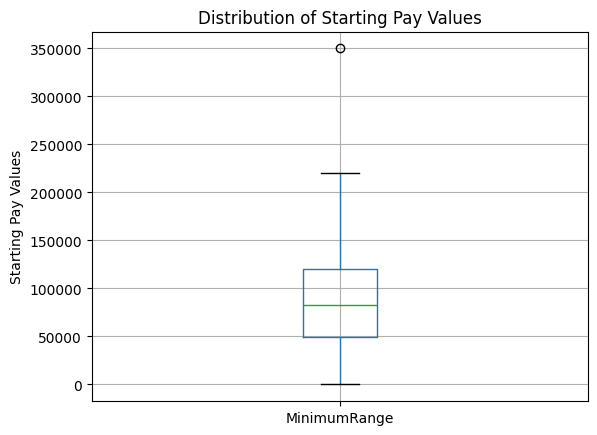

In [72]:
boxplot = Merged_Table.boxplot(column=['MinimumRange'])
plt.title('Distribution of Starting Pay Values')
plt.ylabel('Starting Pay Values');

Graph visualization for Job Listings by State/Territory

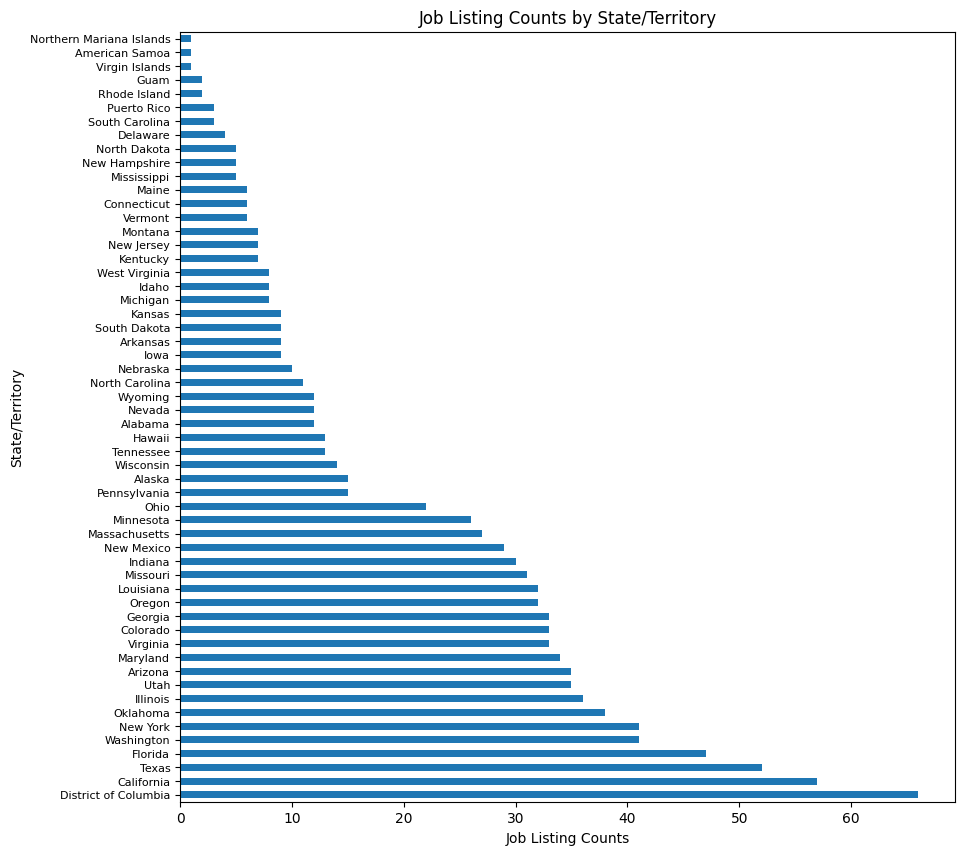

In [73]:
territory_count = Merged_Table['CountrySubDivisionCode'].value_counts()
territory_count.plot(kind='barh', figsize=(10, 10))
plt.title('Job Listing Counts by State/Territory')
plt.xlabel('Job Listing Counts')
plt.ylabel('State/Territory')
plt.yticks(fontsize=8);

Graph visualization for Job Listings by Single/Multiple State Listing

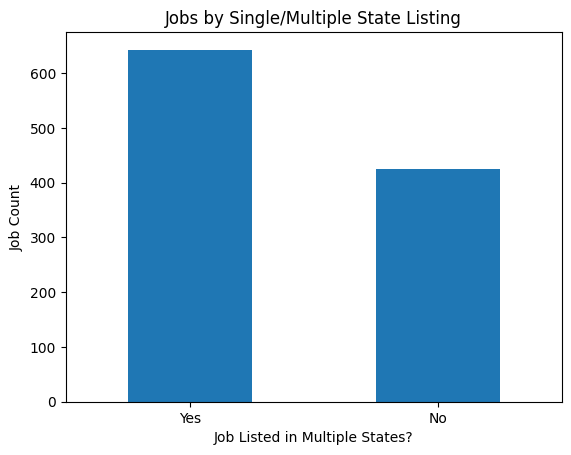

In [74]:
work_count = Merged_Table['MultiState'].value_counts()
work_count.index = work_count.index.map({0:'No',1:'Yes'})
work_count.plot(kind='bar')
plt.title('Jobs by Single/Multiple State Listing')
plt.xlabel('Job Listed in Multiple States?')
plt.ylabel('Job Count')
plt.xticks(rotation=0);

Graph visualization for Jobs Listings by Telework Eligibility

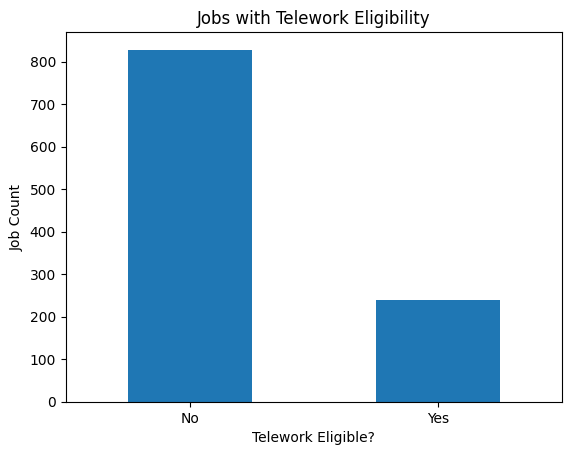

In [75]:
Multistate_count = Merged_Table['TeleworkEligible'].value_counts()
Multistate_count.index = Multistate_count.index.map({0:'No',1:'Yes'})
Multistate_count.plot(kind='bar')
plt.title('Jobs with Telework Eligibility')
plt.xlabel('Telework Eligible?')
plt.ylabel('Job Count')
plt.xticks(rotation=0);

Drop `MinimumRange` Outliers. The dataframe subset calculated using the 1.5 IQR rule shows 15 outliers (visualized by the boxplot).

In [76]:
Merged_Table = Merged_Table[~Merged_Table['PositionID'].isin(Outliers['PositionID'])]

Verify that there are no outliers using the 1.5 IQR rule

In [77]:
Merged_Table[(Merged_Table['MinimumRange']> HighB) | (Merged_Table['MinimumRange']< LowB)]

,PositionID,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible


# Splitting and Encoding for ML Tests

**Create new table `ML_Table`, that drops `PositionID` row, for use in ML tests. Reset index.**

In [78]:
ML_Table = Merged_Table.drop(columns=["PositionID"])
ML_Table = ML_Table.reset_index(drop=True)
ML_Table

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible
0,73939,Alaska,1,0
1,73939,Florida,1,0
2,73939,Vermont,1,0
3,167603,Maryland,0,0
4,142488,Maryland,0,1
...,...,...,...,...
1062,54365,Kentucky,0,0
1063,40332,New York,0,0
1064,54965,Alaska,0,0
1065,40332,Colorado,0,0


Split into testing and training sets.

In [79]:
ML_train, ML_test = train_test_split(ML_Table, random_state = 16)

**Encode Independent variable `CountrySubDivisionCode`. To do this, we will use K-Fold Target Encoding.**

Target Encoding lets us encode numerical values for each possible value of `CountrySubDivisionCode` without greatly increasing dataframe dimensions. K-Fold Target Encoding is used to reduce leakage (which could potentially lead to overfitting).

In [80]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
encoded = pd.Series(index=ML_train.index, dtype=float)
split = kf.split(ML_train)
for train_index, val_index in split:
        train = ML_train.iloc[train_index]
        val = ML_train.iloc[val_index]
        means = train.groupby('CountrySubDivisionCode')['TeleworkEligible'].mean() #Calculates the mean for values grouped by each location in the training split only
        encoded.iloc[val_index] = val['CountrySubDivisionCode'].map(means)

ML_train['SubdivisionEncoded'] = encoded

Create a mean value that will serve as an imputation value for NaN cells for SubdivisionEncoded (both training and testing)

In [81]:
global_means = ML_train.groupby('CountrySubDivisionCode').mean()['SubdivisionEncoded']
imputed_mean = global_means.mean()

In [82]:
ML_train[ML_train.isna().any(axis=1)]

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible,SubdivisionEncoded
787,41235,American Samoa,1,1,NaN
388,51332,South Carolina,1,0,NaN
952,72553,Guam,0,1,NaN
789,41235,Northern Mariana Islands,1,1,NaN


In [83]:
ML_train['SubdivisionEncoded'] =  ML_train['CountrySubDivisionCode'].map(global_means)
ML_test['SubdivisionEncoded'] =  ML_test['CountrySubDivisionCode'].map(global_means)

**Different classification models have different standards for imputing null values in the process of encoding. Logistic regression ideally would use the mean of encoded values, for example, while decision trees would use a placeholder (like `-1`) for imputation. This cell creates versions of the `SubdivisionEncoded` dimension: a version that imputes the mean value that can be referenced for logistic regression testing, and a version that imputes `-1` for reference in decision tree testing.**

In [84]:
Mean_Impute_Train = ML_train['SubdivisionEncoded'].fillna(imputed_mean)
Mean_Impute_Test = ML_test['SubdivisionEncoded'].fillna(imputed_mean)
Placeholder_Impute_Train = ML_train['SubdivisionEncoded'].fillna(-1)
Placeholder_Impute_Test = ML_test['SubdivisionEncoded'].fillna(-1)

ML_train['SubdivisionEncoded'] = Mean_Impute_Train
ML_test['SubdivisionEncoded'] = Mean_Impute_Test

In [85]:
ML_train[ML_train.isna().any(axis=1)] #(Verify lack of NaN values in training table)

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible,SubdivisionEncoded


In [86]:
ML_test[ML_test.isna().any(axis=1)] #(Verify lack of NaN values in testing table)

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible,SubdivisionEncoded


# Machine Learning Classification Tests

Split independent variables (`MinimumRange`, `SubdivisionEncoded`, and `MultiState`) from dependent variable `TeleworkEligible` for both training and testing sets.

In [87]:
X_train = ML_train[['MinimumRange','SubdivisionEncoded','MultiState']]
y_train = ML_train['TeleworkEligible']
X_test = ML_test[['MinimumRange','SubdivisionEncoded','MultiState']]
y_test = ML_test['TeleworkEligible']

**Conduct a Multinomial Logistic Regression classification test.**

In [88]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mlr_accuracy = accuracy_score(y_test, y_pred)
mlr_precision = precision_score(y_test,y_pred,average='weighted')
mlr_recall = recall_score(y_test,y_pred,average='weighted')
mlr_f1 = f1_score(y_test,y_pred,average='weighted')
print("Accuracy:", mlr_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Accuracy: 0.651685393258427

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75       206
           1       0.34      0.54      0.42        61

    accuracy                           0.65       267
   macro avg       0.59      0.61      0.58       267
weighted avg       0.72      0.65      0.68       267


Confusion Matrix:
 [[141  65]
 [ 28  33]]


The logistic regression test has a hard time accurately classifying jobs that are telework eligible (indicated by the "1" label). It is much more likely to accurately indicate jobs that aren't eligible (indicated by the "0" label).

**Conduct a K Nearest Neighbors classification test**

Here, I will construct a graph showing a consecutive range of possible values for the `n_neighbors` parameter (from 1 to 50 inclusive), comparing each value with the associated accuracy test results for both the training and test sets.

This is based on an example from pages 39-40 of Müller and Guido's *Introduction to Machine Learning With Python* (2017).

In [89]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,51)
for n_neighbors in neighbors_settings:
  clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights='distance')
  clf.fit(X_train, y_train)
  training_accuracy.append(clf.score(X_train,y_train))
  test_accuracy.append(clf.score(X_test,y_test))

In [90]:
KNN_Acc_Scores = pd.DataFrame(
    {'n_neighbors': list(neighbors_settings),
     'TrainingScore': training_accuracy,
     'TestScore': test_accuracy}
    )
KNN_Acc_Scores['ScoreDifference'] = KNN_Acc_Scores['TrainingScore'] - KNN_Acc_Scores['TestScore']
KNN_Acc_Scores

,n_neighbors,TrainingScore,TestScore,ScoreDifference
0,1,0.99125,0.895131,0.096119
1,2,0.99125,0.895131,0.096119
2,3,0.99250,0.872659,0.119841
3,4,0.99125,0.868914,0.122336
4,5,0.99250,0.865169,0.127331
5,6,0.99125,0.872659,0.118591
6,7,0.99250,0.876404,0.116096
7,8,0.99250,0.876404,0.116096
8,9,0.99250,0.876404,0.116096
9,10,0.99250,0.880150,0.112350


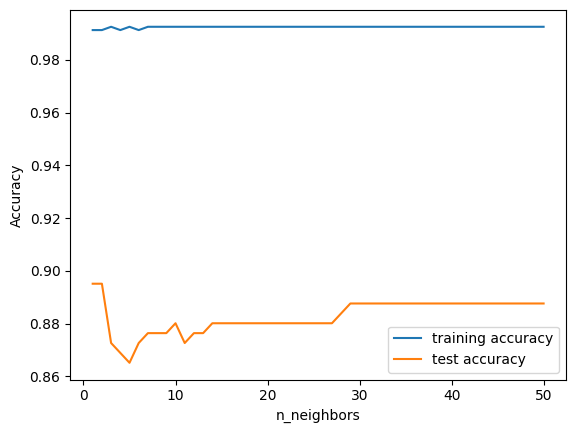

In [91]:
plt.plot(neighbors_settings,training_accuracy,label = "training accuracy")
plt.plot(neighbors_settings,test_accuracy,label = "test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('n_neighbors')
plt.legend()

The table and graph shows a few good values for `n_neighbors`. Let's choose `n_neighbors = 30`.

In [92]:
clf = KNeighborsClassifier(n_neighbors = 30, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test,y_pred,average='weighted')
knn_recall = recall_score(y_test,y_pred,average='weighted')
knn_f1 = f1_score(y_test,y_pred,average='weighted')
print("Accuracy:", knn_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8876404494382022

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       206
           1       0.76      0.74      0.75        61

    accuracy                           0.89       267
   macro avg       0.84      0.83      0.84       267
weighted avg       0.89      0.89      0.89       267


Confusion Matrix:
 [[192  14]
 [ 16  45]]


**Conduct a Decision Tree classification test.**

For decision tree models, it is more ideal to
This cell replaces the original NaN values from the encoded values of `CountrySubDivisionCode` with a placeholder of `-1`.

In [93]:
ML_train['SubdivisionEncoded'] = Placeholder_Impute_Train
ML_test['SubdivisionEncoded'] = Placeholder_Impute_Test
X_train = ML_train[['MinimumRange','SubdivisionEncoded','MultiState']]
y_train = ML_train['TeleworkEligible']
X_test = ML_test[['MinimumRange','SubdivisionEncoded','MultiState']]
y_test = ML_test['TeleworkEligible']

In [94]:
clf = DecisionTreeClassifier(random_state=45, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test,y_pred,average='weighted')
dt_recall = recall_score(y_test,y_pred,average='weighted')
dt_f1 = f1_score(y_test,y_pred,average='weighted')
print("Accuracy:", dt_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8576779026217228

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       206
           1       0.68      0.70      0.69        61

    accuracy                           0.86       267
   macro avg       0.80      0.80      0.80       267
weighted avg       0.86      0.86      0.86       267


Confusion Matrix:
 [[186  20]
 [ 18  43]]


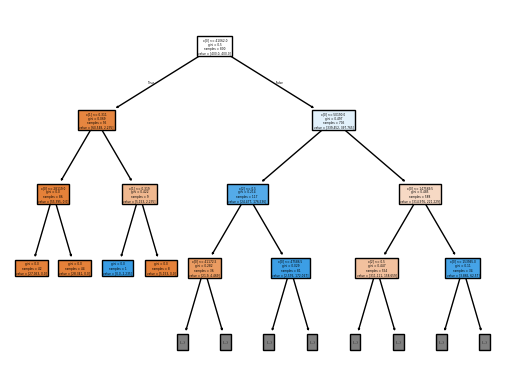

In [95]:
plot_tree(clf,filled = True, max_depth=3)
plt.show()

The decision tree classification test shows not only a higher overall accuracy, but also a better result in ability to classify both for both result catetgories (1 and 0, indicating jobs that are or aren't telework eligible, respectively).

In [96]:
DT_cr_df = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose().round(2)
DT_cr_df

,precision,recall,f1-score,support
0,0.91,0.90,0.91,206.00
1,0.68,0.70,0.69,61.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.80,0.80,0.80,267.00
weighted avg,0.86,0.86,0.86,267.00


**Conduct a SVM Classification test**

For this test, we will scale the `MinimumRange` values using `StandardScaler()`.

In [97]:
scaler = StandardScaler()
ML_train['RangeScaled'] = scaler.fit_transform(ML_train[['MinimumRange']])
ML_train

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible,SubdivisionEncoded,RangeScaled
774,101800,California,0,0,0.237330,0.341827
1006,40332,Iowa,0,0,0.150000,-1.187439
815,41235,Tennessee,1,1,0.448737,-1.164973
1064,54965,Alaska,0,0,0.225253,-0.823384
753,142488,District of Columbia,0,0,0.376027,1.354107
...,...,...,...,...,...,...
452,144040,Indiana,1,0,0.154745,1.392719
635,146481,Louisiana,1,0,0.152589,1.453449
581,22360,Louisiana,1,0,0.152589,-1.634565
121,120579,New York,1,0,0.094635,0.809031


In [98]:
print(ML_train['RangeScaled'].min())
print(ML_train['RangeScaled'].max())

-1.634565397805312
3.282532462262249


In [99]:
ML_test['RangeScaled'] = scaler.transform(ML_test[['MinimumRange']])
ML_test

,MinimumRange,CountrySubDivisionCode,MultiState,TeleworkEligible,SubdivisionEncoded,RangeScaled
210,142488,Utah,1,0,0.231607,1.354107
300,46148,Alabama,1,1,0.484127,-1.042742
863,56654,Arkansas,0,0,0.316667,-0.781363
30,120579,Colorado,1,0,0.194814,0.809031
661,40332,Missouri,1,0,0.112185,-1.187439
...,...,...,...,...,...,...
527,92000,District of Columbia,0,0,0.376027,0.098012
70,120579,Colorado,1,0,0.194814,0.809031
270,99606,Washington,0,0,0.202601,0.287243
514,74441,Nevada,1,0,0.636905,-0.338839


In [100]:
X_train = ML_train[['RangeScaled','SubdivisionEncoded','MultiState']]
y_train = ML_train['TeleworkEligible']
X_test = ML_test[['RangeScaled','SubdivisionEncoded','MultiState']]
y_test = ML_test['TeleworkEligible']

In [101]:
svm = SVC(random_state = 50, class_weight='balanced')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test,y_pred,average='weighted')
svm_recall = recall_score(y_test,y_pred,average='weighted')
svm_f1 = f1_score(y_test,y_pred,average='weighted')
print("Accuracy:", svm_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6441947565543071

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.63      0.73       206
           1       0.36      0.70      0.48        61

    accuracy                           0.64       267
   macro avg       0.62      0.67      0.60       267
weighted avg       0.76      0.64      0.67       267


Confusion Matrix:
 [[129  77]
 [ 18  43]]


In [102]:
SVC_cr_df = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose().round(2)
SVC_cr_df

,precision,recall,f1-score,support
0,0.88,0.63,0.73,206.00
1,0.36,0.70,0.48,61.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.62,0.67,0.60,267.00
weighted avg,0.76,0.64,0.67,267.00


**Compare metrics for each model (Accuracy, Precision, Recall & F1 scores)**

In [103]:
SummaryTable = pd.DataFrame({'Model':['Multinomial Logistic Regression','K-Nearest Neighbors','Decision Tree','Support Vector Machine'],
                             'Accuracy':[mlr_accuracy,knn_accuracy,dt_accuracy,svm_accuracy],
                             'Precision (weighted)':[mlr_precision,knn_precision,dt_precision,svm_precision],
                             'Recall (weighted)':[mlr_recall,knn_recall,dt_recall,svm_recall],
                             'F1 (weighted)':[mlr_f1,knn_f1,dt_f1,svm_f1]
                             },
                             )
SummaryTable = SummaryTable.round(4)
SummaryTable

,Model,Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
0,Multinomial Logistic Regression,0.6517,0.7206,0.6517,0.6750
1,K-Nearest Neighbors,0.8876,0.8864,0.8876,0.8870
2,Decision Tree,0.8577,0.8594,0.8577,0.8585
3,Support Vector Machine,0.6442,0.7589,0.6442,0.6725


From these metrics, we see that K-Nearest Neighbors is the best performing model, followed closely by the Decision Tree. The Logistic Regression and SVM models show middling results.